In [1]:
import os
import h5py
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path

In [2]:
def get_Higgs_result(total_event, total_Higgs, correct_event, correct_Higgs, nh, nj):

    start_nj, end_nj = nj

    label = ['all' if nh == 'all' else f'{nh}h' for nj in range(start_nj, end_nj+2)]

    if nh == 'all':
        nh = slice(1, None)
        
    event_type = [f'Nj={nj}' for nj in range(start_nj, end_nj)]
    event_type.append(f'Nj>={end_nj}')
    event_type.append('Total')

    event_fraction = [total_event[nh, nj].sum() / total_event.sum() for nj in range(start_nj, end_nj)]
    event_fraction.append(total_event[nh, end_nj:].sum() / total_event.sum())
    event_fraction.append(total_event[nh].sum() / total_event.sum())

    event_efficiency = [correct_event[nh, nj].sum() / total_event[nh, nj].sum() for nj in range(start_nj, end_nj)]
    event_efficiency.append(correct_event[nh, end_nj:].sum() / total_event[nh, end_nj:].sum())
    event_efficiency.append(correct_event[nh].sum() / total_event[nh].sum())

    higgs_efficiency = [correct_Higgs[nh, nj].sum() / total_Higgs[nh, nj].sum() for nj in range(start_nj, end_nj)]
    higgs_efficiency.append(correct_Higgs[nh, end_nj:].sum() / total_Higgs[nh, end_nj:].sum())
    higgs_efficiency.append(correct_Higgs[nh].sum() / total_Higgs[nh].sum())
        
    result = {'Label':label,
              'Event type': event_type,
              'Event Fraction': event_fraction,
              'Event Efficiency': event_efficiency,
              'Higgs Efficiency': higgs_efficiency,
             }

    df = pd.DataFrame(result)

    return df

In [3]:
def compare_jet_list_triHiggs(pair1, pair2, nh_max=3):
    h1_true = {pair1[0], pair1[1]}
    h2_true = {pair1[2], pair1[3]}
    h3_true = {pair1[4], pair1[5]}  
    
    h1_test = {pair2[0], pair2[1]}
    h2_test = {pair2[2], pair2[3]}
    h3_test = {pair2[4], pair2[5]}
    
    test_h = [h1_test, h2_test, h3_test]
    
    # bug
    nh = 0
    for id1, id2, id3 in itertools.permutations([0, 1, 2]):
        h1 = test_h[id1]
        h2 = test_h[id2]
        h3 = test_h[id3]
        if h1_true == h1:
            nh = 1
            if h2_true == h2:
                nh = 2
                if h3_true == h3:
                    nh = 3
                    break
                    
    same = True if nh==nh_max else False
    return same, nh

def compare_jet_list_triHiggs_optimized(pair1, pair2, nh_max=3):
    # 將pair1和pair2分別轉換為三個Higgs的集合
    h_true_sets = [{pair1[i], pair1[i+1]} for i in range(0, 6, 2)]
    h_test_sets = [{pair2[i], pair2[i+1]} for i in range(0, 6, 2)]
    
    # 計算匹配的Higgs數量
    nh = sum(1 for h_true in h_true_sets if h_true in h_test_sets)
    
    # 判斷是否所有Higgs都匹配
    same = nh == nh_max
    return same, nh

In [4]:
def get_particle_mask(quark_jet, particle_quarks):
    # quark_jet: 每個夸克對應的 jet 編號，shape 為 (n_event, 6)
    # particle_quarks: 粒子對應的夸克編號，shape 為 (n_quarks,)

    # 檢查是否每個夸克都有對應的 jet
    mask1 = np.all(quark_jet[:, particle_quarks] != -1, axis=1)

    # 對每一個事件，檢查每個夸克對應的 jet 都不重複
    count = np.array([[np.sum(event == event[i]) for i in particle_quarks] for event in quark_jet])
    mask2 = np.all(count == 1, axis=1)

    return mask1 & mask2

In [5]:
def get_Higgs_correct_fraction(events, nh, nj, jet_type='Nj'):
    # events: number of events in different categories (nh, nj, n_correct_h)
    start_nj, end_nj = nj

    label = [f'{nh}h' for _ in range(start_nj, end_nj+2)]

    total_event = events[nh].sum(axis=1)

    correct_3h_event = events[nh, :, 3]
    correct_2h_event = events[nh, :, 2]
    correct_1h_event = events[nh, :, 1]
    correct_0h_event = events[nh, :, 0]

    correct_Higgs = events[nh, :, 3] * 3 + events[nh, :, 2] * 2 + events[nh, :, 1]
        
    event_type = [f'{jet_type}={nj}' for nj in range(start_nj, end_nj)]
    event_type.append(f'{jet_type}>={end_nj}')
    event_type.append('Total')

    event_fraction = [total_event[nj] / total_event.sum() for nj in range(start_nj, end_nj)]
    event_fraction.append(total_event[end_nj:].sum() / total_event.sum())
    event_fraction.append(total_event.sum() / total_event.sum())


    eff_3h = [correct_3h_event[nj] / total_event[nj] for nj in range(start_nj, end_nj)]
    eff_3h.append(correct_3h_event[end_nj:].sum() / total_event[end_nj:].sum())
    eff_3h.append(correct_3h_event.sum() / total_event.sum())

    eff_2h = [correct_2h_event[nj] / total_event[nj] for nj in range(start_nj, end_nj)]
    eff_2h.append(correct_2h_event[end_nj:].sum() / total_event[end_nj:].sum())
    eff_2h.append(correct_2h_event.sum() / total_event.sum())

    eff_1h = [correct_1h_event[nj] / total_event[nj] for nj in range(start_nj, end_nj)]
    eff_1h.append(correct_1h_event[end_nj:].sum() / total_event[end_nj:].sum())
    eff_1h.append(correct_1h_event.sum() / total_event.sum())

    eff_0h = [correct_0h_event[nj] / total_event[nj] for nj in range(start_nj, end_nj)]
    eff_0h.append(correct_0h_event[end_nj:].sum() / total_event[end_nj:].sum())
    eff_0h.append(correct_0h_event.sum() / total_event.sum())

    eff_Higgs = [correct_Higgs[nj] / (total_event[nj] * nh) for nj in range(start_nj, end_nj)]
    eff_Higgs.append(correct_Higgs[end_nj:].sum() / (total_event[end_nj:].sum() * nh))
    eff_Higgs.append(correct_Higgs.sum() / (total_event.sum() * nh))
        
    result = {'Label':label,
              'Event type': event_type,
              'Event Fraction': event_fraction,
              '3h': eff_3h,
              '2h': eff_2h,
              '1h': eff_1h,
              '0h': eff_0h,
              'Higgs': eff_Higgs
             }

    df = pd.DataFrame(result)

    return df


In [6]:
def compute_pairing_efficiency(true_file, test_file, save_path=None):
    MAX_JETS = 15

    with h5py.File(true_file, 'r') as f_true, h5py.File(test_file, 'r') as f_test:
        
        # events: 總共有多少該類事件 (nh, nj, n_correct_h)
        events = np.zeros((4, MAX_JETS + 1, 4))

        # nevent = f_true['INPUTS/Source/pt'].shape[0]
        nevent = min(100000, f_true['INPUTS/Source/pt'].shape[0])
        # ramdomly choose events
        np.random.seed(1301)
        indices = np.random.choice(range(f_true['INPUTS/Source/pt'].shape[0]), nevent, replace=False)

        for event in tqdm(indices):

            nj = f_true['INPUTS/Source/MASK'][event].sum()

            h1_b1 = f_true['TARGETS/h1/b1'][event]
            h1_b2 = f_true['TARGETS/h1/b2'][event]
            h2_b1 = f_true['TARGETS/h2/b1'][event]
            h2_b2 = f_true['TARGETS/h2/b2'][event]
            h3_b1 = f_true['TARGETS/h3/b1'][event]
            h3_b2 = f_true['TARGETS/h3/b2'][event]

            quark_jet = np.array([h1_b1, h1_b2, h2_b1, h2_b2, h3_b1, h3_b2]).reshape(1, 6)

            h1_mask = get_particle_mask(quark_jet, [0, 1])
            h2_mask = get_particle_mask(quark_jet, [2, 3])
            h3_mask = get_particle_mask(quark_jet, [4, 5])

            event_h = [h1_mask, h2_mask, h3_mask].count(True)

            true_pair = [h1_b1,h1_b2, h2_b1,h2_b2, h3_b1,h3_b2]

            try: 
                h1_b1 = f_test['TARGETS/h1/b1'][event]
                h1_b2 = f_test['TARGETS/h1/b2'][event]
                h2_b1 = f_test['TARGETS/h2/b1'][event]
                h2_b2 = f_test['TARGETS/h2/b2'][event]
                h3_b1 = f_test['TARGETS/h3/b1'][event]
                h3_b2 = f_test['TARGETS/h3/b2'][event]
            except KeyError:
                h1_b1 = f_test['SpecialKey.Targets/h1/b1'][event]
                h1_b2 = f_test['SpecialKey.Targets/h1/b2'][event]
                h2_b1 = f_test['SpecialKey.Targets/h2/b1'][event]
                h2_b2 = f_test['SpecialKey.Targets/h2/b2'][event]
                h3_b1 = f_test['SpecialKey.Targets/h3/b1'][event]
                h3_b2 = f_test['SpecialKey.Targets/h3/b2'][event]
            pair = [h1_b1,h1_b2, h2_b1,h2_b2, h3_b1,h3_b2]


            if event_h == 3:
                _, nh = compare_jet_list_triHiggs_optimized(true_pair, pair, nh_max=3)
                events[3, nj, nh] += 1
            elif event_h == 2:
                _, nh = compare_jet_list_triHiggs_optimized(true_pair, pair, nh_max=2)
                events[2, nj, nh] += 1
            elif event_h == 1:
                _, nh = compare_jet_list_triHiggs_optimized(true_pair, pair, nh_max=1)
                events[1, nj, nh] += 1
            elif event_h == 0:
                events[0, nj, 0] += 1
        
        
        df_3h = get_Higgs_correct_fraction(events, nh=3, nj=(6, 8), jet_type='Nj')  
        print('3 Higgs Events:')
        print(df_3h)
        
        if save_path is not None:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            df_3h.to_csv(save_path, index=False)

        df_style = df_3h.style.format({
            'Event Fraction': '{:.3f}',
            '3h': '{:.3f}',
            '2h': '{:.3f}',
            '1h': '{:.3f}',
            '0h': '{:.3f}',
            'Higgs': '{:.3f}'
        })
        print(df_style.to_latex(column_format='c|cccc|c'))


# DM-CPV

In [7]:
file_path = './Sample/SPANet/triHiggs-4pT40_4b-mix-test.h5'
output_path = './Sample/SPANet/triHiggs-4pT40_4b-mix-test-4b_SPANet_pairing.h5'

compute_pairing_efficiency(file_path, output_path)

100%|██████████| 200000/200000 [09:39<00:00, 345.36it/s]


3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.220804  0.434105  0.000000  0.400612  0.165283   
1    3h       Nj=7        0.334405  0.289327  0.067019  0.414038  0.229615   
2    3h      Nj>=8        0.444791  0.190125  0.100051  0.402877  0.306947   
3    3h      Total        1.000000  0.277170  0.066913  0.406109  0.249807   

      Higgs  
0  0.567642  
1  0.472019  
2  0.391118  
3  0.457149  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.221 & 0.434 & 0.000 & 0.401 & 0.165 & 0.568 \\
1 & 3h & Nj=7 & 0.334 & 0.289 & 0.067 & 0.414 & 0.230 & 0.472 \\
2 & 3h & Nj>=8 & 0.445 & 0.190 & 0.100 & 0.403 & 0.307 & 0.391 \\
3 & 3h & Total & 1.000 & 0.277 & 0.067 & 0.406 & 0.250 & 0.457 \\
\end{tabular}



## Evaluate the pairing performance at each mass point

In [20]:
for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:
    print(f'gghhh_bsm_{m3_m2}')
    true_path = f'./Sample/SPANet/sig/gghhh_bsm_{m3_m2}/gghhh-4pT40_4b-test.h5'
    predict_path = f'./Sample/SPANet/sig/gghhh_bsm_{m3_m2}/gghhh-4pT40_4b-test-4b_SPANet_predict.h5'
    csv_path = f'./pairing_performance/gghhh_bsm_{m3_m2}/gghhh-4pT40_4b-test-4b_SPANet_pairing.csv'
    compute_pairing_efficiency(true_path, predict_path, save_path=csv_path)

for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:
    print(f'gghhh_bsm_{m3_m2}')
    true_path = f'./Sample/SPANet/sig/gghhh_bsm_{m3_m2}/gghhh-4pT40_4b-test.h5'
    predict_path = f'./Sample/SPANet/sig/gghhh_bsm_{m3_m2}/gghhh-4pT40_4b-test-chi2_pairing.h5'
    csv_path = f'./pairing_performance/gghhh_bsm_{m3_m2}/gghhh-4pT40_4b-test-chi2_pairing.csv'
    compute_pairing_efficiency(true_path, predict_path, save_path=csv_path)

for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:
    print(f'gghhh_bsm_{m3_m2}')
    true_path = f'./Sample/SPANet/sig/gghhh_bsm_{m3_m2}/gghhh-4pT40_4b-test.h5'
    predict_path = f'./Sample/SPANet/sig/gghhh_bsm_{m3_m2}/gghhh-4pT40_4b-test-abs_pairing.h5'
    csv_path = f'./pairing_performance/gghhh_bsm_{m3_m2}/gghhh-4pT40_4b-test-abs_pairing.csv'
    compute_pairing_efficiency(true_path, predict_path, save_path=csv_path)

gghhh_bsm_420_280


100%|██████████| 25000/25000 [00:58<00:00, 428.98it/s]


3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.243485  0.432319  0.000000  0.412907  0.154774   
1    3h       Nj=7        0.340445  0.311820  0.056285  0.413133  0.218762   
2    3h      Nj>=8        0.416071  0.213387  0.083205  0.419097  0.284311   
3    3h      Total        1.000000  0.300204  0.053781  0.415560  0.230455   

      Higgs  
0  0.569955  
1  0.487054  
2  0.408556  
3  0.474578  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.243 & 0.432 & 0.000 & 0.413 & 0.155 & 0.570 \\
1 & 3h & Nj=7 & 0.340 & 0.312 & 0.056 & 0.413 & 0.219 & 0.487 \\
2 & 3h & Nj>=8 & 0.416 & 0.213 & 0.083 & 0.419 & 0.284 & 0.409 \\
3 & 3h & Total & 1.000 & 0.300 & 0.054 & 0.416 & 0.230 & 0.475 \\
\end{tabular}

gghhh_bsm_500_275


100%|██████████| 25000/25000 [00:58<00:00, 429.87it/s]


3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.221003  0.397754  0.000000  0.413712  0.188534   
1    3h       Nj=7        0.340778  0.256420  0.075891  0.414718  0.252970   
2    3h      Nj>=8        0.438218  0.168107  0.096572  0.411326  0.323994   
3    3h      Total        1.000000  0.248955  0.068182  0.413009  0.269854   

      Higgs  
0  0.535658  
1  0.445254  
2  0.369598  
3  0.432079  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.221 & 0.398 & 0.000 & 0.414 & 0.189 & 0.536 \\
1 & 3h & Nj=7 & 0.341 & 0.256 & 0.076 & 0.415 & 0.253 & 0.445 \\
2 & 3h & Nj>=8 & 0.438 & 0.168 & 0.097 & 0.411 & 0.324 & 0.370 \\
3 & 3h & Total & 1.000 & 0.249 & 0.068 & 0.413 & 0.270 & 0.432 \\
\end{tabular}

gghhh_bsm_500_300


100%|██████████| 25000/25000 [00:58<00:00, 428.90it/s]


3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.208950  0.459426  0.000000  0.375229  0.165345   
1    3h       Nj=7        0.318205  0.304087  0.055689  0.419071  0.221154   
2    3h      Nj>=8        0.472845  0.203559  0.100027  0.396333  0.300081   
3    3h      Total        1.000000  0.289011  0.065018  0.399159  0.246813   

      Higgs  
0  0.584503  
1  0.480903  
2  0.402355  
3  0.465409  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.209 & 0.459 & 0.000 & 0.375 & 0.165 & 0.585 \\
1 & 3h & Nj=7 & 0.318 & 0.304 & 0.056 & 0.419 & 0.221 & 0.481 \\
2 & 3h & Nj>=8 & 0.473 & 0.204 & 0.100 & 0.396 & 0.300 & 0.402 \\
3 & 3h & Total & 1.000 & 0.289 & 0.065 & 0.399 & 0.247 & 0.465 \\
\end{tabular}

gghhh_bsm_520_325


100%|██████████| 25000/25000 [00:58<00:00, 427.57it/s]

3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.209727  0.448466  0.000000  0.398160  0.153374   
1    3h       Nj=7        0.338394  0.285171  0.079848  0.409506  0.225475   
2    3h      Nj>=8        0.451879  0.175399  0.119021  0.386674  0.318907   
3    3h      Total        1.000000  0.269815  0.080803  0.396809  0.252573   

      Higgs  
0  0.581186  
1  0.474905  
2  0.383637  
3  0.455953  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.210 & 0.448 & 0.000 & 0.398 & 0.153 & 0.581 \\
1 & 3h & Nj=7 & 0.338 & 0.285 & 0.080 & 0.410 & 0.225 & 0.475 \\
2 & 3h & Nj>=8 & 0.452 & 0.175 & 0.119 & 0.387 & 0.319 & 0.384 \\
3 & 3h & Total & 1.000 & 0.270 & 0.081 & 0.397 & 0.253 & 0.456 \\
\end{tabular}



In [46]:
for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:
    print(f'gghhh_bsm_{m3_m2}')
    true_path = f'./Sample/SPANet/sig/gghhh_bsm_{m3_m2}/gghhh-4pT40_6b-1.h5'
    predict_path = f'./Sample/SPANet/sig/gghhh_bsm_{m3_m2}/gghhh-4pT40_6b-1-4b_SPANet_predict.h5'
    csv_path = f'./pairing_performance/gghhh_bsm_{m3_m2}/gghhh-4pT40_6b-1-4b_SPANet_pairing.csv'
    compute_pairing_efficiency(true_path, predict_path, save_path=csv_path)

for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:
    print(f'gghhh_bsm_{m3_m2}')
    true_path = f'./Sample/SPANet/sig/gghhh_bsm_{m3_m2}/gghhh-4pT40_6b-1.h5'
    predict_path = f'./Sample/SPANet/sig/gghhh_bsm_{m3_m2}/gghhh-4pT40_6b-1-chi2_pairing.h5'
    csv_path = f'./pairing_performance/gghhh_bsm_{m3_m2}/gghhh-4pT40_6b-1-chi2_pairing.csv'
    compute_pairing_efficiency(true_path, predict_path, save_path=csv_path)

for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:
    print(f'gghhh_bsm_{m3_m2}')
    true_path = f'./Sample/SPANet/sig/gghhh_bsm_{m3_m2}/gghhh-4pT40_6b-1.h5'
    predict_path = f'./Sample/SPANet/sig/gghhh_bsm_{m3_m2}/gghhh-4pT40_6b-1-abs_pairing.h5'
    csv_path = f'./pairing_performance/gghhh_bsm_{m3_m2}/gghhh-4pT40_6b-1-abs_pairing.csv'
    compute_pairing_efficiency(true_path, predict_path, save_path=csv_path)

gghhh_bsm_420_280


100%|██████████| 12500/12500 [00:29<00:00, 430.75it/s]


3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.220331  0.496825  0.000000  0.370370  0.132804   
1    3h       Nj=7        0.314409  0.366333  0.029663  0.416389  0.187616   
2    3h      Nj>=8        0.465260  0.262841  0.065147  0.415936  0.256076   
3    3h      Total        1.000000  0.346934  0.039636  0.406039  0.207391   

      Higgs  
0  0.620282  
1  0.524904  
2  0.444918  
3  0.508704  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.220 & 0.497 & 0.000 & 0.370 & 0.133 & 0.620 \\
1 & 3h & Nj=7 & 0.314 & 0.366 & 0.030 & 0.416 & 0.188 & 0.525 \\
2 & 3h & Nj>=8 & 0.465 & 0.263 & 0.065 & 0.416 & 0.256 & 0.445 \\
3 & 3h & Total & 1.000 & 0.347 & 0.040 & 0.406 & 0.207 & 0.509 \\
\end{tabular}

gghhh_bsm_500_275


100%|██████████| 12500/12500 [00:29<00:00, 430.87it/s]


3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.182518  0.432806  0.000000  0.393939  0.173254   
1    3h       Nj=7        0.294337  0.306781  0.034722  0.417484  0.241013   
2    3h      Nj>=8        0.523145  0.205930  0.069409  0.392324  0.332337   
3    3h      Total        1.000000  0.277023  0.046531  0.400024  0.276422   

      Higgs  
0  0.564119  
1  0.469090  
2  0.382977  
3  0.441385  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.183 & 0.433 & 0.000 & 0.394 & 0.173 & 0.564 \\
1 & 3h & Nj=7 & 0.294 & 0.307 & 0.035 & 0.417 & 0.241 & 0.469 \\
2 & 3h & Nj>=8 & 0.523 & 0.206 & 0.069 & 0.392 & 0.332 & 0.383 \\
3 & 3h & Total & 1.000 & 0.277 & 0.047 & 0.400 & 0.276 & 0.441 \\
\end{tabular}

gghhh_bsm_500_300


100%|██████████| 12500/12500 [00:29<00:00, 429.76it/s]


3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.177469  0.450167  0.000000  0.397993  0.151839   
1    3h       Nj=7        0.300451  0.375346  0.036744  0.384433  0.203477   
2    3h      Nj>=8        0.522080  0.234879  0.072533  0.395407  0.297181   
3    3h      Total        1.000000  0.315290  0.048908  0.392569  0.243234   

      Higgs  
0  0.582832  
1  0.527986  
2  0.415037  
3  0.478751  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.177 & 0.450 & 0.000 & 0.398 & 0.152 & 0.583 \\
1 & 3h & Nj=7 & 0.300 & 0.375 & 0.037 & 0.384 & 0.203 & 0.528 \\
2 & 3h & Nj>=8 & 0.522 & 0.235 & 0.073 & 0.395 & 0.297 & 0.415 \\
3 & 3h & Total & 1.000 & 0.315 & 0.049 & 0.393 & 0.243 & 0.479 \\
\end{tabular}

gghhh_bsm_520_325


100%|██████████| 12500/12500 [00:29<00:00, 430.45it/s]


3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.160249  0.440939  0.000000  0.369741  0.189320   
1    3h       Nj=7        0.288733  0.328693  0.053435  0.392905  0.224966   
2    3h      Nj>=8        0.551018  0.201647  0.084706  0.392706  0.320941   
3    3h      Total        1.000000  0.276676  0.062103  0.389083  0.272138   

      Higgs  
0  0.564186  
1  0.495285  
2  0.389020  
3  0.447772  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.160 & 0.441 & 0.000 & 0.370 & 0.189 & 0.564 \\
1 & 3h & Nj=7 & 0.289 & 0.329 & 0.053 & 0.393 & 0.225 & 0.495 \\
2 & 3h & Nj>=8 & 0.551 & 0.202 & 0.085 & 0.393 & 0.321 & 0.389 \\
3 & 3h & Total & 1.000 & 0.277 & 0.062 & 0.389 & 0.272 & 0.448 \\
\end{tabular}

gghhh_bsm_420_280


100%|██████████| 12500/12500 [00:28<00:00, 436.14it/s]


3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.220331  0.527513  0.000000  0.355556  0.116931   
1    3h       Nj=7        0.314409  0.430478  0.029663  0.363367  0.176492   
2    3h      Nj>=8        0.465260  0.323728  0.056878  0.364320  0.255074   
3    3h      Total        1.000000  0.402192  0.035789  0.362089  0.199930   

      Higgs  
0  0.646032  
1  0.571376  
2  0.483087  
3  0.546747  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.220 & 0.528 & 0.000 & 0.356 & 0.117 & 0.646 \\
1 & 3h & Nj=7 & 0.314 & 0.430 & 0.030 & 0.363 & 0.176 & 0.571 \\
2 & 3h & Nj>=8 & 0.465 & 0.324 & 0.057 & 0.364 & 0.255 & 0.483 \\
3 & 3h & Total & 1.000 & 0.402 & 0.036 & 0.362 & 0.200 & 0.547 \\
\end{tabular}

gghhh_bsm_500_275


100%|██████████| 12500/12500 [00:28<00:00, 434.95it/s]


3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.182518  0.407773  0.000000  0.381423  0.210804   
1    3h       Nj=7        0.294337  0.308007  0.021242  0.375000  0.295752   
2    3h      Nj>=8        0.523145  0.195357  0.052861  0.382211  0.369570   
3    3h      Total        1.000000  0.267284  0.033906  0.379945  0.318865   

      Higgs  
0  0.534914  
1  0.447168  
2  0.358002  
3  0.416536  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.183 & 0.408 & 0.000 & 0.381 & 0.211 & 0.535 \\
1 & 3h & Nj=7 & 0.294 & 0.308 & 0.021 & 0.375 & 0.296 & 0.447 \\
2 & 3h & Nj>=8 & 0.523 & 0.195 & 0.053 & 0.382 & 0.370 & 0.358 \\
3 & 3h & Total & 1.000 & 0.267 & 0.034 & 0.380 & 0.319 & 0.417 \\
\end{tabular}

gghhh_bsm_500_300


100%|██████████| 12500/12500 [00:28<00:00, 436.62it/s]


3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.177469  0.371237  0.000000  0.391304  0.237458   
1    3h       Nj=7        0.300451  0.311339  0.019360  0.395891  0.273410   
2    3h      Nj>=8        0.522080  0.191905  0.044111  0.396317  0.367667   
3    3h      Total        1.000000  0.259615  0.028846  0.395299  0.316239   

      Higgs  
0  0.501672  
1  0.456210  
2  0.353418  
3  0.410613  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.177 & 0.371 & 0.000 & 0.391 & 0.237 & 0.502 \\
1 & 3h & Nj=7 & 0.300 & 0.311 & 0.019 & 0.396 & 0.273 & 0.456 \\
2 & 3h & Nj>=8 & 0.522 & 0.192 & 0.044 & 0.396 & 0.368 & 0.353 \\
3 & 3h & Total & 1.000 & 0.260 & 0.029 & 0.395 & 0.316 & 0.411 \\
\end{tabular}

gghhh_bsm_520_325


100%|██████████| 12500/12500 [00:28<00:00, 437.00it/s]


3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.160249  0.363269  0.000000  0.403722  0.233010   
1    3h       Nj=7        0.288733  0.287831  0.034127  0.393354  0.284688   
2    3h      Nj>=8        0.551018  0.180941  0.054824  0.387765  0.376471   
3    3h      Total        1.000000  0.241022  0.040062  0.391936  0.326980   

      Higgs  
0  0.497843  
1  0.441700  
2  0.346745  
3  0.398375  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.160 & 0.363 & 0.000 & 0.404 & 0.233 & 0.498 \\
1 & 3h & Nj=7 & 0.289 & 0.288 & 0.034 & 0.393 & 0.285 & 0.442 \\
2 & 3h & Nj>=8 & 0.551 & 0.181 & 0.055 & 0.388 & 0.376 & 0.347 \\
3 & 3h & Total & 1.000 & 0.241 & 0.040 & 0.392 & 0.327 & 0.398 \\
\end{tabular}

gghhh_bsm_420_280


100%|██████████| 12500/12500 [00:28<00:00, 436.63it/s]


3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.220331  0.465079  0.000000  0.381481  0.153439   
1    3h       Nj=7        0.314409  0.374490  0.028550  0.381164  0.215795   
2    3h      Nj>=8        0.465260  0.295665  0.054623  0.372839  0.276873   
3    3h      Total        1.000000  0.357776  0.034390  0.377361  0.230473   

      Higgs  
0  0.592240  
1  0.520578  
2  0.456360  
3  0.506489  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.220 & 0.465 & 0.000 & 0.381 & 0.153 & 0.592 \\
1 & 3h & Nj=7 & 0.314 & 0.374 & 0.029 & 0.381 & 0.216 & 0.521 \\
2 & 3h & Nj>=8 & 0.465 & 0.296 & 0.055 & 0.373 & 0.277 & 0.456 \\
3 & 3h & Total & 1.000 & 0.358 & 0.034 & 0.377 & 0.230 & 0.506 \\
\end{tabular}

gghhh_bsm_500_275


100%|██████████| 12500/12500 [00:28<00:00, 436.45it/s]


3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.182518  0.456522  0.000000  0.353755  0.189723   
1    3h       Nj=7        0.294337  0.349265  0.023693  0.378268  0.248775   
2    3h      Nj>=8        0.523145  0.220179  0.056539  0.385888  0.337394   
3    3h      Total        1.000000  0.301311  0.036552  0.377780  0.284357   

      Higgs  
0  0.574440  
1  0.491149  
2  0.386501  
3  0.451605  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.183 & 0.457 & 0.000 & 0.354 & 0.190 & 0.574 \\
1 & 3h & Nj=7 & 0.294 & 0.349 & 0.024 & 0.378 & 0.249 & 0.491 \\
2 & 3h & Nj>=8 & 0.523 & 0.220 & 0.057 & 0.386 & 0.337 & 0.387 \\
3 & 3h & Total & 1.000 & 0.301 & 0.037 & 0.378 & 0.284 & 0.452 \\
\end{tabular}

gghhh_bsm_500_300


100%|██████████| 12500/12500 [00:28<00:00, 437.49it/s]


3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.177469  0.439465  0.000000  0.367224  0.193311   
1    3h       Nj=7        0.300451  0.362702  0.022916  0.371000  0.243382   
2    3h      Nj>=8        0.522080  0.232833  0.052524  0.370396  0.344247   
3    3h      Total        1.000000  0.308523  0.034307  0.370014  0.287156   

      Higgs  
0  0.561873  
1  0.501646  
2  0.391314  
3  0.454733  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.177 & 0.439 & 0.000 & 0.367 & 0.193 & 0.562 \\
1 & 3h & Nj=7 & 0.300 & 0.363 & 0.023 & 0.371 & 0.243 & 0.502 \\
2 & 3h & Nj>=8 & 0.522 & 0.233 & 0.053 & 0.370 & 0.344 & 0.391 \\
3 & 3h & Total & 1.000 & 0.309 & 0.034 & 0.370 & 0.287 & 0.455 \\
\end{tabular}

gghhh_bsm_520_325


100%|██████████| 12500/12500 [00:28<00:00, 436.67it/s]

3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.160249  0.433657  0.000000  0.372168  0.194175   
1    3h       Nj=7        0.288733  0.333633  0.037719  0.380781  0.247867   
2    3h      Nj>=8        0.551018  0.212000  0.068471  0.380941  0.338588   
3    3h      Total        1.000000  0.282640  0.048619  0.379489  0.289252   

      Higgs  
0  0.557713  
1  0.485706  
2  0.384627  
3  0.441549  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.160 & 0.434 & 0.000 & 0.372 & 0.194 & 0.558 \\
1 & 3h & Nj=7 & 0.289 & 0.334 & 0.038 & 0.381 & 0.248 & 0.486 \\
2 & 3h & Nj>=8 & 0.551 & 0.212 & 0.068 & 0.381 & 0.339 & 0.385 \\
3 & 3h & Total & 1.000 & 0.283 & 0.049 & 0.379 & 0.289 & 0.442 \\
\end{tabular}



# TRSM

## 5 mass points: 250k

In [1]:
m3_m2_list = [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]

In [7]:
file_path = './Sample/SPANet/TRSM/triHiggs_TRSM-4pT40_4b-mix_5-test.h5'
output_path = './Sample/SPANet/TRSM/triHiggs_TRSM-4pT40_4b-mix_5-test-4b_SPANet_pairing.h5'
compute_pairing_efficiency(file_path, output_path)

file_path = './Sample/SPANet/TRSM/triHiggs_TRSM-4pT40_6b-mix_5.h5'
output_path = './Sample/SPANet/TRSM/triHiggs_TRSM-4pT40_6b-mix_5-4b_SPANet_pairing.h5'
compute_pairing_efficiency(file_path, output_path)

100%|██████████| 100000/100000 [04:01<00:00, 414.92it/s]


3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.209148  0.343194  0.000000  0.450998  0.205808   
1    3h       Nj=7        0.320364  0.281872  0.058412  0.414929  0.244787   
2    3h      Nj>=8        0.470488  0.174587  0.081807  0.421460  0.322146   
3    3h      Total        1.000000  0.244221  0.057203  0.425546  0.273031   

      Higgs  
0  0.493527  
1  0.459123  
2  0.369611  
3  0.424204  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.209 & 0.343 & 0.000 & 0.451 & 0.206 & 0.494 \\
1 & 3h & Nj=7 & 0.320 & 0.282 & 0.058 & 0.415 & 0.245 & 0.459 \\
2 & 3h & Nj>=8 & 0.470 & 0.175 & 0.082 & 0.421 & 0.322 & 0.370 \\
3 & 3h & Total & 1.000 & 0.244 & 0.057 & 0.426 & 0.273 & 0.424 \\
\end{tabular}



100%|██████████| 100000/100000 [03:59<00:00, 417.57it/s]

3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.179158  0.399140  0.000000  0.416336  0.184524   
1    3h       Nj=7        0.307216  0.305274  0.028541  0.422717  0.243467   
2    3h      Nj>=8        0.513626  0.212469  0.056520  0.416575  0.314436   
3    3h      Total        1.000000  0.274424  0.037798  0.418419  0.269358   

      Higgs  
0  0.537919  
1  0.465207  
2  0.389007  
3  0.439096  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.179 & 0.399 & 0.000 & 0.416 & 0.185 & 0.538 \\
1 & 3h & Nj=7 & 0.307 & 0.305 & 0.029 & 0.423 & 0.243 & 0.465 \\
2 & 3h & Nj>=8 & 0.514 & 0.212 & 0.057 & 0.417 & 0.314 & 0.389 \\
3 & 3h & Total & 1.000 & 0.274 & 0.038 & 0.418 & 0.269 & 0.439 \\
\end{tabular}



In [3]:
# (4b test, 6b test) x (chi2 pairing, abs pairing)
for pairing_method in ['chi2_pairing', 'abs_pairing']:
    for m3, m2 in m3_m2_list:

        true_path = f'./Sample/SPANet/TRSM/TRSM_{m3}_{m2}/gghhh-4pT40_4b-test.h5'
        predict_path = f'./Sample/SPANet/TRSM/TRSM_{m3}_{m2}/gghhh-4pT40_4b-test-{pairing_method}.h5'
        csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_4b-test-{pairing_method}.csv'
        cmd = f'python evaluate_pairing_performance.py {true_path} {predict_path} {csv_path} &'
        print(cmd)

        true_path = f'./Sample/SPANet/TRSM/TRSM_{m3}_{m2}/gghhh-4pT40_6b-1.h5'
        predict_path = f'./Sample/SPANet/TRSM/TRSM_{m3}_{m2}/gghhh-4pT40_6b-1-{pairing_method}.h5'
        csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_6b-1-{pairing_method}.csv'
        cmd = f'python evaluate_pairing_performance.py {true_path} {predict_path} {csv_path} &'
        print(cmd)

python evaluate_pairing_performance.py ./Sample/SPANet/TRSM/TRSM_420_280/gghhh-4pT40_4b-test.h5 ./Sample/SPANet/TRSM/TRSM_420_280/gghhh-4pT40_4b-test-chi2_pairing.h5 ./pairing_performance/TRSM_420_280/gghhh-4pT40_4b-test-chi2_pairing.csv &
python evaluate_pairing_performance.py ./Sample/SPANet/TRSM/TRSM_420_280/gghhh-4pT40_6b-1.h5 ./Sample/SPANet/TRSM/TRSM_420_280/gghhh-4pT40_6b-1-chi2_pairing.h5 ./pairing_performance/TRSM_420_280/gghhh-4pT40_6b-1-chi2_pairing.csv &
python evaluate_pairing_performance.py ./Sample/SPANet/TRSM/TRSM_500_275/gghhh-4pT40_4b-test.h5 ./Sample/SPANet/TRSM/TRSM_500_275/gghhh-4pT40_4b-test-chi2_pairing.h5 ./pairing_performance/TRSM_500_275/gghhh-4pT40_4b-test-chi2_pairing.csv &
python evaluate_pairing_performance.py ./Sample/SPANet/TRSM/TRSM_500_275/gghhh-4pT40_6b-1.h5 ./Sample/SPANet/TRSM/TRSM_500_275/gghhh-4pT40_6b-1-chi2_pairing.h5 ./pairing_performance/TRSM_500_275/gghhh-4pT40_6b-1-chi2_pairing.csv &
python evaluate_pairing_performance.py ./Sample/SPANet/TRS

In [4]:
# (4b test, 6b test) x (mix_5-4b_SPANet_pairing)
for m3, m2 in m3_m2_list:
    true_path = f'./Sample/SPANet/TRSM/TRSM_{m3}_{m2}/gghhh-4pT40_4b-test.h5'
    predict_path = f'./Sample/SPANet/TRSM/TRSM_{m3}_{m2}/gghhh-4pT40_4b-test-mix_5-4b_SPANet_pairing.h5'
    csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_4b-test-mix_5-4b_SPANet_pairing.csv'
    cmd = f'python evaluate_pairing_performance.py {true_path} {predict_path} {csv_path} &'
    print(cmd)
    
    true_path = f'./Sample/SPANet/TRSM/TRSM_{m3}_{m2}/gghhh-4pT40_6b-1.h5'
    predict_path = f'./Sample/SPANet/TRSM/TRSM_{m3}_{m2}/gghhh-4pT40_6b-1-mix_5-4b_SPANet_pairing.h5'
    csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_6b-1-mix_5-4b_SPANet_pairing.csv'
    cmd = f'python evaluate_pairing_performance.py {true_path} {predict_path} {csv_path} &'
    print(cmd)

python evaluate_pairing_performance.py ./Sample/SPANet/TRSM/TRSM_420_280/gghhh-4pT40_4b-test.h5 ./Sample/SPANet/TRSM/TRSM_420_280/gghhh-4pT40_4b-test-mix_5-4b_SPANet_pairing.h5 ./pairing_performance/TRSM_420_280/gghhh-4pT40_4b-test-mix_5-4b_SPANet_pairing.csv &
python evaluate_pairing_performance.py ./Sample/SPANet/TRSM/TRSM_420_280/gghhh-4pT40_6b-1.h5 ./Sample/SPANet/TRSM/TRSM_420_280/gghhh-4pT40_6b-1-mix_5-4b_SPANet_pairing.h5 ./pairing_performance/TRSM_420_280/gghhh-4pT40_6b-1-mix_5-4b_SPANet_pairing.csv &
python evaluate_pairing_performance.py ./Sample/SPANet/TRSM/TRSM_500_275/gghhh-4pT40_4b-test.h5 ./Sample/SPANet/TRSM/TRSM_500_275/gghhh-4pT40_4b-test-mix_5-4b_SPANet_pairing.h5 ./pairing_performance/TRSM_500_275/gghhh-4pT40_4b-test-mix_5-4b_SPANet_pairing.csv &
python evaluate_pairing_performance.py ./Sample/SPANet/TRSM/TRSM_500_275/gghhh-4pT40_6b-1.h5 ./Sample/SPANet/TRSM/TRSM_500_275/gghhh-4pT40_6b-1-mix_5-4b_SPANet_pairing.h5 ./pairing_performance/TRSM_500_275/gghhh-4pT40_6b-1-

## 5 mass points: 1M

In [7]:
m3_m2_list = [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]

In [8]:
pairing_method = '4b_SPANet_pairing-mix_5-1M'
file_path = '../Sample/SPANet/TRSM/gghhh-4pT40_4b-mix_5-test.h5'
output_path = f'../Sample/SPANet/TRSM/gghhh-4pT40_4b-mix_5-test-{pairing_method}.h5'
compute_pairing_efficiency(file_path, output_path)

file_path = '../Sample/SPANet/TRSM/gghhh-4pT40_6b-mix_5-test.h5'
output_path = f'../Sample/SPANet/TRSM/gghhh-4pT40_6b-mix_5-test-{pairing_method}.h5'
compute_pairing_efficiency(file_path, output_path)

100%|██████████| 100000/100000 [04:08<00:00, 402.68it/s]


3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.213549  0.494327  0.000000  0.360542  0.145130   
1    3h       Nj=7        0.320024  0.378822  0.053190  0.377642  0.190345   
2    3h      Nj>=8        0.466428  0.275971  0.085132  0.387817  0.251079   
3    3h      Total        1.000000  0.355516  0.056730  0.378736  0.209018   

      Higgs  
0  0.614508  
1  0.540163  
2  0.461999  
3  0.519581  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.214 & 0.494 & 0.000 & 0.361 & 0.145 & 0.615 \\
1 & 3h & Nj=7 & 0.320 & 0.379 & 0.053 & 0.378 & 0.190 & 0.540 \\
2 & 3h & Nj>=8 & 0.466 & 0.276 & 0.085 & 0.388 & 0.251 & 0.462 \\
3 & 3h & Total & 1.000 & 0.356 & 0.057 & 0.379 & 0.209 & 0.520 \\
\end{tabular}



100%|██████████| 50000/50000 [01:58<00:00, 423.41it/s]

3 Higgs Events:
  Label Event type  Event Fraction        3h        2h        1h        0h  \
0    3h       Nj=6        0.182856  0.535106  0.000000  0.336306  0.128588   
1    3h       Nj=7        0.303505  0.427511  0.031946  0.363619  0.176925   
2    3h      Nj>=8        0.513639  0.303816  0.063615  0.386769  0.245800   
3    3h      Total        1.000000  0.383651  0.042371  0.370515  0.203463   

      Higgs  
0  0.647208  
1  0.570014  
2  0.475149  
3  0.535403  
\begin{tabular}{c|cccc|c}
 & Label & Event type & Event Fraction & 3h & 2h & 1h & 0h & Higgs \\
0 & 3h & Nj=6 & 0.183 & 0.535 & 0.000 & 0.336 & 0.129 & 0.647 \\
1 & 3h & Nj=7 & 0.304 & 0.428 & 0.032 & 0.364 & 0.177 & 0.570 \\
2 & 3h & Nj>=8 & 0.514 & 0.304 & 0.064 & 0.387 & 0.246 & 0.475 \\
3 & 3h & Total & 1.000 & 0.384 & 0.042 & 0.371 & 0.203 & 0.535 \\
\end{tabular}



In [9]:
# (4b test, 6b test) x (chi2 pairing, abs pairing)
for pairing_method in ['chi2_pairing', 'abs_pairing']:
    for n in [4, 6]:
        for m3, m2 in m3_m2_list:
            sig_dir = Path(f'../Sample/SPANet/TRSM/TRSM_{m3}_{m2}')
            true_path = sig_dir / f'gghhh-4pT40_{n}b-test.h5'
            predict_path = sig_dir / f'gghhh-4pT40_{n}b-test-{pairing_method}.h5'
            csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_{n}b-test-{pairing_method}.csv'
            cmd = f'python evaluate_pairing_performance.py {true_path} {predict_path} {csv_path} &'
            print(cmd)

python evaluate_pairing_performance.py ../Sample/SPANet/TRSM/TRSM_420_280/gghhh-4pT40_4b-test.h5 ../Sample/SPANet/TRSM/TRSM_420_280/gghhh-4pT40_4b-test-chi2_pairing.h5 ./pairing_performance/TRSM_420_280/gghhh-4pT40_4b-test-chi2_pairing.csv &
python evaluate_pairing_performance.py ../Sample/SPANet/TRSM/TRSM_500_275/gghhh-4pT40_4b-test.h5 ../Sample/SPANet/TRSM/TRSM_500_275/gghhh-4pT40_4b-test-chi2_pairing.h5 ./pairing_performance/TRSM_500_275/gghhh-4pT40_4b-test-chi2_pairing.csv &
python evaluate_pairing_performance.py ../Sample/SPANet/TRSM/TRSM_500_300/gghhh-4pT40_4b-test.h5 ../Sample/SPANet/TRSM/TRSM_500_300/gghhh-4pT40_4b-test-chi2_pairing.h5 ./pairing_performance/TRSM_500_300/gghhh-4pT40_4b-test-chi2_pairing.csv &
python evaluate_pairing_performance.py ../Sample/SPANet/TRSM/TRSM_520_325/gghhh-4pT40_4b-test.h5 ../Sample/SPANet/TRSM/TRSM_520_325/gghhh-4pT40_4b-test-chi2_pairing.h5 ./pairing_performance/TRSM_520_325/gghhh-4pT40_4b-test-chi2_pairing.csv &
python evaluate_pairing_performa

In [10]:
# (4b test, 6b test) x (mix_5-4b_SPANet_pairing)
pairing_method = '4b_SPANet_pairing-mix_5-1M'
for n in [4, 6]:
    for m3, m2 in m3_m2_list:
        sig_dir = Path(f'../Sample/SPANet/TRSM/TRSM_{m3}_{m2}')
        true_path = sig_dir / f'gghhh-4pT40_{n}b-test.h5'
        predict_path = sig_dir / f'gghhh-4pT40_{n}b-test-{pairing_method}.h5'
        csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_{n}b-test-{pairing_method}.csv'
        cmd = f'python evaluate_pairing_performance.py {true_path} {predict_path} {csv_path} &'
        print(cmd)

python evaluate_pairing_performance.py ../Sample/SPANet/TRSM/TRSM_420_280/gghhh-4pT40_4b-test.h5 ../Sample/SPANet/TRSM/TRSM_420_280/gghhh-4pT40_4b-test-4b_SPANet_pairing-mix_5-1M.h5 ./pairing_performance/TRSM_420_280/gghhh-4pT40_4b-test-4b_SPANet_pairing-mix_5-1M.csv &
python evaluate_pairing_performance.py ../Sample/SPANet/TRSM/TRSM_500_275/gghhh-4pT40_4b-test.h5 ../Sample/SPANet/TRSM/TRSM_500_275/gghhh-4pT40_4b-test-4b_SPANet_pairing-mix_5-1M.h5 ./pairing_performance/TRSM_500_275/gghhh-4pT40_4b-test-4b_SPANet_pairing-mix_5-1M.csv &
python evaluate_pairing_performance.py ../Sample/SPANet/TRSM/TRSM_500_300/gghhh-4pT40_4b-test.h5 ../Sample/SPANet/TRSM/TRSM_500_300/gghhh-4pT40_4b-test-4b_SPANet_pairing-mix_5-1M.h5 ./pairing_performance/TRSM_500_300/gghhh-4pT40_4b-test-4b_SPANet_pairing-mix_5-1M.csv &
python evaluate_pairing_performance.py ../Sample/SPANet/TRSM/TRSM_520_325/gghhh-4pT40_4b-test.h5 ../Sample/SPANet/TRSM/TRSM_520_325/gghhh-4pT40_4b-test-4b_SPANet_pairing-mix_5-1M.h5 ./pairin

# Plot the event efficiency

## DM-CPV

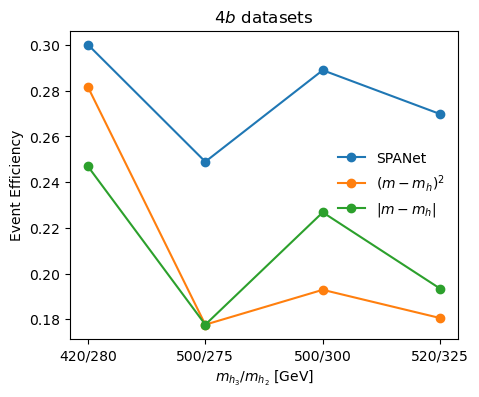

In [ ]:
# load pairing results
SPANet_effs = [] 
chi2_effs = []
abs_effs = []

for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:

    csv_path = f'./pairing_performance/gghhh_bsm_{m3_m2}/gghhh-4pT40_4b-test-4b_SPANet_pairing.csv'
    df = pd.read_csv(csv_path)
    SPANet_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/gghhh_bsm_{m3_m2}/gghhh-4pT40_4b-test-chi2_pairing.csv'
    df = pd.read_csv(csv_path)
    chi2_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/gghhh_bsm_{m3_m2}/gghhh-4pT40_4b-test-abs_pairing.csv'
    df = pd.read_csv(csv_path)
    abs_effs.append(df[df['Event type'] == 'Total']['3h'])

# plot the results
m3_m2 = ['420/280', '500/275', '500/300', '520/325']
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(m3_m2, SPANet_effs, marker='o', label='SPANet')
ax.plot(m3_m2, chi2_effs, marker='o', label='$(m - m_h)^2$')
ax.plot(m3_m2, abs_effs, marker='o', label='$|m - m_h|$')
ax.set_title('$4b$ datasets')
ax.set_xlabel('$m_{h_3}/m_{h_2}$ [GeV]')
ax.set_ylabel('Event Efficiency')
ax.legend(frameon=False)

plt.savefig('./figures/pairing_performance-4b_datasets.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

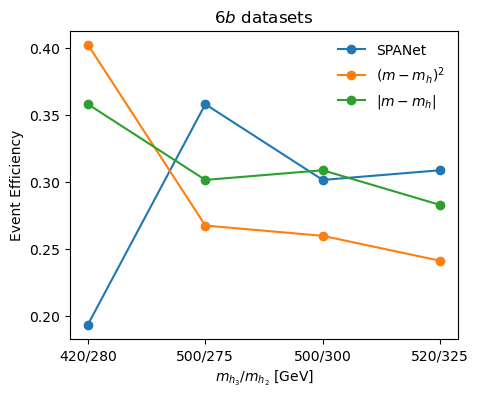

In [ ]:
# load pairing results
SPANet_effs = [] 
chi2_effs = []
abs_effs = []

for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:

    csv_path = f'./pairing_performance/gghhh_bsm_{m3_m2}/gghhh-4pT40_6b-1-4b_SPANet_pairing.csv'
    SPANet_effs.append(df[df['Event type'] == 'Total']['3h'])
    df = pd.read_csv(csv_path)

    csv_path = f'./pairing_performance/gghhh_bsm_{m3_m2}/gghhh-4pT40_6b-1-chi2_pairing.csv'
    df = pd.read_csv(csv_path)
    chi2_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/gghhh_bsm_{m3_m2}/gghhh-4pT40_6b-1-abs_pairing.csv'
    df = pd.read_csv(csv_path)
    abs_effs.append(df[df['Event type'] == 'Total']['3h'])

# plot the results
m3_m2 = ['420/280', '500/275', '500/300', '520/325']
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(m3_m2, SPANet_effs, marker='o', label='SPANet')
ax.plot(m3_m2, chi2_effs, marker='o', label='$(m - m_h)^2$')
ax.plot(m3_m2, abs_effs, marker='o', label='$|m - m_h|$')
ax.set_title('$6b$ datasets')
ax.set_xlabel('$m_{h_3}/m_{h_2}$ [GeV]')
ax.set_ylabel('Event Efficiency')
ax.legend(frameon=False)

plt.savefig('./figures/pairing_performance-6b_datasets.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## TRSM

### 4 mass point: 250k

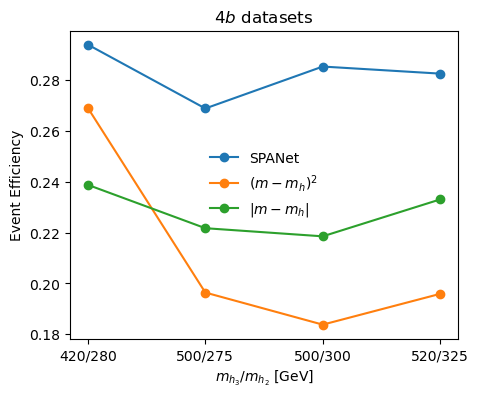

In [ ]:
# load pairing results
SPANet_effs = [] 
chi2_effs = []
abs_effs = []

for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:

    csv_path = f'./pairing_performance/TRSM_{m3_m2}/gghhh-4pT40_4b-test-4b_SPANet_pairing.csv'
    df = pd.read_csv(csv_path)
    SPANet_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/TRSM_{m3_m2}/gghhh-4pT40_4b-test-chi2_pairing.csv'
    df = pd.read_csv(csv_path)
    chi2_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/TRSM_{m3_m2}/gghhh-4pT40_4b-test-abs_pairing.csv'
    df = pd.read_csv(csv_path)
    abs_effs.append(df[df['Event type'] == 'Total']['3h'])

# plot the results
m3_m2 = ['420/280', '500/275', '500/300', '520/325']
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(m3_m2, SPANet_effs, marker='o', label='SPANet')
ax.plot(m3_m2, chi2_effs, marker='o', label='$(m - m_h)^2$')
ax.plot(m3_m2, abs_effs, marker='o', label='$|m - m_h|$')
ax.set_title('$4b$ datasets')
ax.set_xlabel('$m_{h_3}/m_{h_2}$ [GeV]')
ax.set_ylabel('Event Efficiency')
ax.legend(frameon=False)

plt.savefig('./figures/pairing_performance-4b_datasets-TRSM.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

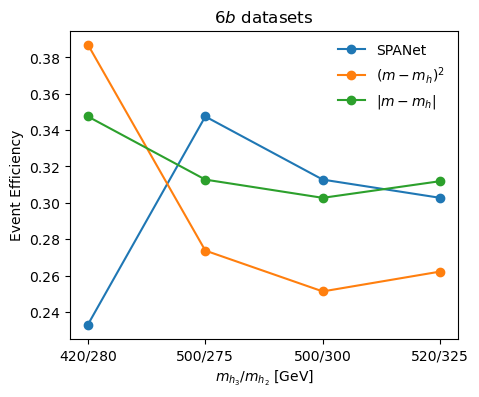

In [ ]:
# load pairing results
SPANet_effs = [] 
chi2_effs = []
abs_effs = []

for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:

    csv_path = f'./pairing_performance/TRSM_{m3_m2}/gghhh-4pT40_6b-1-4b_SPANet_pairing.csv'
    SPANet_effs.append(df[df['Event type'] == 'Total']['3h'])
    df = pd.read_csv(csv_path)

    csv_path = f'./pairing_performance/TRSM_{m3_m2}/gghhh-4pT40_6b-1-chi2_pairing.csv'
    df = pd.read_csv(csv_path)
    chi2_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/TRSM_{m3_m2}/gghhh-4pT40_6b-1-abs_pairing.csv'
    df = pd.read_csv(csv_path)
    abs_effs.append(df[df['Event type'] == 'Total']['3h'])

# plot the results
m3_m2 = ['420/280', '500/275', '500/300', '520/325']
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(m3_m2, SPANet_effs, marker='o', label='SPANet')
ax.plot(m3_m2, chi2_effs, marker='o', label='$(m - m_h)^2$')
ax.plot(m3_m2, abs_effs, marker='o', label='$|m - m_h|$')
ax.set_title('$6b$ datasets')
ax.set_xlabel('$m_{h_3}/m_{h_2}$ [GeV]')
ax.set_ylabel('Event Efficiency')
ax.legend(frameon=False)

plt.savefig('./figures/pairing_performance-6b_datasets-TRSM.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

### 4 mass point: 750k

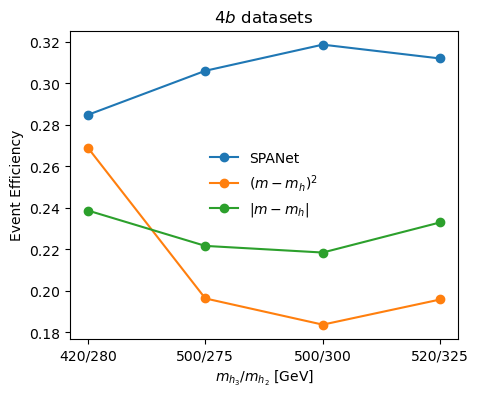

In [10]:
# load pairing results
SPANet_effs = [] 
chi2_effs = []
abs_effs = []

for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:

    csv_path = f'./pairing_performance/TRSM_{m3_m2}/gghhh-4pT40_4b-test-4b_SPANet_pairing.csv'
    df = pd.read_csv(csv_path)
    SPANet_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/TRSM_{m3_m2}/gghhh-4pT40_4b-test-chi2_pairing.csv'
    df = pd.read_csv(csv_path)
    chi2_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/TRSM_{m3_m2}/gghhh-4pT40_4b-test-abs_pairing.csv'
    df = pd.read_csv(csv_path)
    abs_effs.append(df[df['Event type'] == 'Total']['3h'])

# plot the results
m3_m2 = ['420/280', '500/275', '500/300', '520/325']
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(m3_m2, SPANet_effs, marker='o', label='SPANet')
ax.plot(m3_m2, chi2_effs, marker='o', label='$(m - m_h)^2$')
ax.plot(m3_m2, abs_effs, marker='o', label='$|m - m_h|$')
ax.set_title('$4b$ datasets')
ax.set_xlabel('$m_{h_3}/m_{h_2}$ [GeV]')
ax.set_ylabel('Event Efficiency')
ax.legend(frameon=False)

plt.savefig('./figures/pairing_performance-4b_datasets-750k-TRSM.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

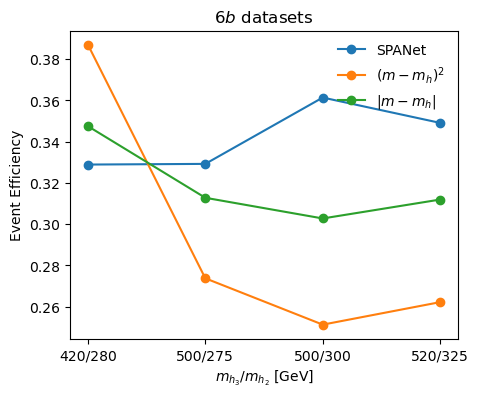

In [11]:
# load pairing results
SPANet_effs = [] 
chi2_effs = []
abs_effs = []

for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:

    csv_path = f'./pairing_performance/TRSM_{m3_m2}/gghhh-4pT40_6b-1-4b_SPANet_pairing.csv'
    df = pd.read_csv(csv_path)
    SPANet_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/TRSM_{m3_m2}/gghhh-4pT40_6b-1-chi2_pairing.csv'
    df = pd.read_csv(csv_path)
    chi2_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/TRSM_{m3_m2}/gghhh-4pT40_6b-1-abs_pairing.csv'
    df = pd.read_csv(csv_path)
    abs_effs.append(df[df['Event type'] == 'Total']['3h'])

# plot the results
m3_m2 = ['420/280', '500/275', '500/300', '520/325']
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(m3_m2, SPANet_effs, marker='o', label='SPANet')
ax.plot(m3_m2, chi2_effs, marker='o', label='$(m - m_h)^2$')
ax.plot(m3_m2, abs_effs, marker='o', label='$|m - m_h|$')
ax.set_title('$6b$ datasets')
ax.set_xlabel('$m_{h_3}/m_{h_2}$ [GeV]')
ax.set_ylabel('Event Efficiency')
ax.legend(frameon=False)

plt.savefig('./figures/pairing_performance-6b_datasets-750k-TRSM.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

### 5 mass point: 250k

In [5]:
m3_m2_list = [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]

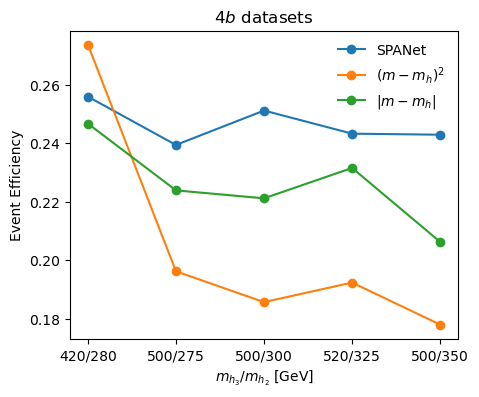

In [6]:
# load pairing results
SPANet_effs = [] 
chi2_effs = []
abs_effs = []

for m3, m2 in m3_m2_list:

    csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_4b-test-mix_5-4b_SPANet_pairing.csv'
    df = pd.read_csv(csv_path)
    SPANet_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_4b-test-chi2_pairing.csv'
    df = pd.read_csv(csv_path)
    chi2_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_4b-test-abs_pairing.csv'
    df = pd.read_csv(csv_path)
    abs_effs.append(df[df['Event type'] == 'Total']['3h'])

# plot the results
m3_m2 = [f'{m3}/{m2}' for m3, m2 in m3_m2_list]
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(m3_m2, SPANet_effs, marker='o', label='SPANet')
ax.plot(m3_m2, chi2_effs, marker='o', label='$(m - m_h)^2$')
ax.plot(m3_m2, abs_effs, marker='o', label='$|m - m_h|$')
ax.set_title('$4b$ datasets')
ax.set_xlabel('$m_{h_3}/m_{h_2}$ [GeV]')
ax.set_ylabel('Event Efficiency')
ax.legend(frameon=False)

plt.savefig('../figures/pairing_performance-4b_datasets-mix_5-250k-TRSM.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

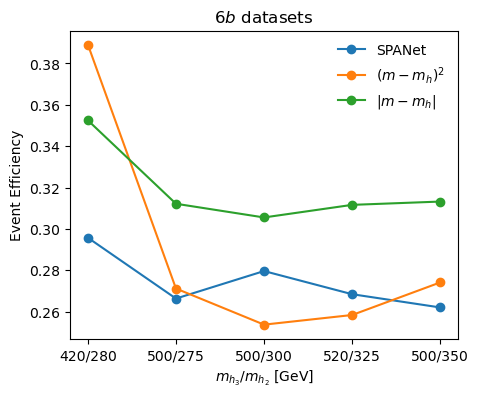

In [7]:
# load pairing results
SPANet_effs = [] 
chi2_effs = []
abs_effs = []

for m3, m2 in m3_m2_list:

    csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_6b-1-mix_5-4b_SPANet_pairing.csv'
    df = pd.read_csv(csv_path)
    SPANet_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_6b-1-chi2_pairing.csv'
    df = pd.read_csv(csv_path)
    chi2_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_6b-1-abs_pairing.csv'
    df = pd.read_csv(csv_path)
    abs_effs.append(df[df['Event type'] == 'Total']['3h'])

# plot the results
m3_m2 = [f'{m3}/{m2}' for m3, m2 in m3_m2_list]
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(m3_m2, SPANet_effs, marker='o', label='SPANet')
ax.plot(m3_m2, chi2_effs, marker='o', label='$(m - m_h)^2$')
ax.plot(m3_m2, abs_effs, marker='o', label='$|m - m_h|$')
ax.set_title('$6b$ datasets')
ax.set_xlabel('$m_{h_3}/m_{h_2}$ [GeV]')
ax.set_ylabel('Event Efficiency')
ax.legend(frameon=False)

plt.savefig('../figures/pairing_performance-6b_datasets-mix_5-250k-TRSM.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

### 5 mass point: 1M

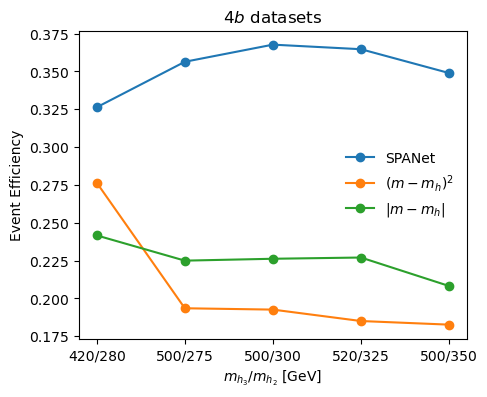

In [11]:
# load pairing results
SPANet_effs = [] 
chi2_effs = []
abs_effs = []

for m3, m2 in [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]:

    csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_4b-test-4b_SPANet_pairing-mix_5-1M.csv'
    df = pd.read_csv(csv_path)
    SPANet_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_4b-test-chi2_pairing.csv'
    df = pd.read_csv(csv_path)
    chi2_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_4b-test-abs_pairing.csv'
    df = pd.read_csv(csv_path)
    abs_effs.append(df[df['Event type'] == 'Total']['3h'])

# plot the results
m3_m2 = [f'{m3}/{m2}' for m3, m2 in [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]]
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(m3_m2, SPANet_effs, marker='o', label='SPANet')
ax.plot(m3_m2, chi2_effs, marker='o', label='$(m - m_h)^2$')
ax.plot(m3_m2, abs_effs, marker='o', label='$|m - m_h|$')
ax.set_title('$4b$ datasets')
ax.set_xlabel('$m_{h_3}/m_{h_2}$ [GeV]')
ax.set_ylabel('Event Efficiency')
ax.legend(frameon=False)

plt.savefig('../figures/pairing_performance-4b_datasets-mix_5-1M-TRSM.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

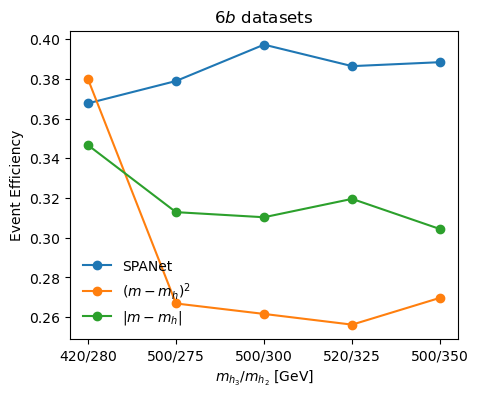

In [12]:
# load pairing results
SPANet_effs = [] 
chi2_effs = []
abs_effs = []

for m3, m2 in [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]:

    csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_6b-test-4b_SPANet_pairing-mix_5-1M.csv'
    df = pd.read_csv(csv_path)
    SPANet_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_6b-test-chi2_pairing.csv'
    df = pd.read_csv(csv_path)
    chi2_effs.append(df[df['Event type'] == 'Total']['3h'])

    csv_path = f'./pairing_performance/TRSM_{m3}_{m2}/gghhh-4pT40_6b-test-abs_pairing.csv'
    df = pd.read_csv(csv_path)
    abs_effs.append(df[df['Event type'] == 'Total']['3h'])

# plot the results
m3_m2 = [f'{m3}/{m2}' for m3, m2 in [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]]
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(m3_m2, SPANet_effs, marker='o', label='SPANet')
ax.plot(m3_m2, chi2_effs, marker='o', label='$(m - m_h)^2$')
ax.plot(m3_m2, abs_effs, marker='o', label='$|m - m_h|$')
ax.set_title('$6b$ datasets')
ax.set_xlabel('$m_{h_3}/m_{h_2}$ [GeV]')
ax.set_ylabel('Event Efficiency')
ax.legend(frameon=False)

plt.savefig('../figures/pairing_performance-6b_datasets-mix_5-1M-TRSM.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()